# 导入库

In [1]:
from one_pair import one_pair_path
import torch
import torchvision
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import PIL.ImageOps 
print(torch.__version__)  #1.1.0
print(torchvision.__version__)  #0.3.0
import cv2

1.7.0
0.8.1


# pytorch中加载数据的顺序是：
## 1创建一个dataset对象
## 2创建一个dataloader对象
## 3dataloader加载dataset
## 4循环dataloader对象，将data,label拿到模型中去训练

dataset：传入的数据
shuffle = True:是否打乱数据

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,input_dir,transform=None,should_invert=True):
         #传入一个文件夹路径
#         self.imageFolderDataset = imageFolderDataset   
        #传入一个transform类
        self.transform = transform                 
        self.should_invert = should_invert
        
        self.my_pair=one_pair_path(input_dir)
        
    def __getitem__(self,index):
        #index 自动有，0-length
        should_get_same_class = random.randint(0,1) #保证同类样本约占一半
        a=0
        b=0
        c=0
        if should_get_same_class:
            a,b,c=self.my_pair.same_pair()
        else:
            a,b,c=self.my_pair.diff_pair()

        img0 = Image.open(a)
        img1 = Image.open(b)
        #灰度图像，每个像素用8个bit表示，0表示黑，255表示白，其他数字表示不同的灰度
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
#         return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
        return img0, img1, torch.from_numpy(np.array([int(c)],dtype=np.float32))
    
    def __len__(self):
        #使用方法  a=SiameseNetworkDataset()
        #使用方法  len(a)
        return self.my_pair.len_img_list()

# 显示tensor

In [3]:
%matplotlib inline

In [4]:
def imshow(tensor_img,text=None,should_save=False): 
    #1 tensor到cvimg
    array1=tensor_img.numpy()#将tensor数据转为numpy数据
    maxValue=array1.max()
    array1=array1*255/maxValue#normalize，将图像数据扩展到[0,255]
    mat=np.uint8(array1)#float32-->uint8
    print('mat_shape:',mat.shape)#mat_shape: (3, 982, 814)
    mat=mat.transpose(1,2,0)#mat_shape: (982, 814，3)
    # cvimg到PIL
    image = Image.fromarray(cv2.cvtColor(mat,cv2.COLOR_BGR2RGB))
    plt.imshow(image) #转换为(H,W,C)
    plt.show()  
    
#     #展示一幅tensor图像，输入是(C,H,W)
#     npimg = img.numpy() #将tensor转为ndarray
#     plt.axis("off")
#     if text:
#         plt.text(75, 8, text, style='italic',fontweight='bold',
#             bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
#     plt.imshow(np.transpose(npimg, (1, 2, 0))) #转换为(H,W,C)
#     plt.show()    
def show_plot(iteration,loss):
    #绘制损失变化图
    plt.plot(iteration,loss)
    plt.show()

mat_shape: (1, 100, 100)


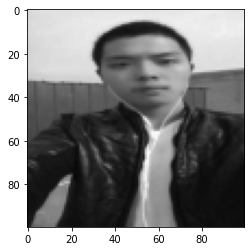

mat_shape: (1, 100, 100)


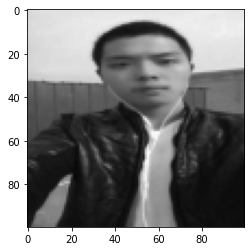

tensor([1.])


In [5]:
#定义一些超参
train_batch_size = 4        #训练时batch_size
train_number_epochs = 50     #训练的epoch
 #训练集地址
training_dir = "./data_folder" 

folder_dataset = torchvision.datasets.ImageFolder(root=training_dir)
# print('folder_dataset:')
# print(folder_dataset)
# print('folder_dataset[1]:')
# print(folder_dataset[1])


# transforms.Compose()类详解：串联多个transform操作
transform = transforms.Compose([transforms.Resize((100,100)), #有坑，传入int和tuple有区别
                                transforms.ToTensor()])


#定义图像dataset
siamese_dataset = SiameseNetworkDataset(input_dir=training_dir,
                                        transform=transform,
                                        should_invert=False)
# print('siamese_dataset:')
# print(siamese_dataset)
# print(siamese_dataset[1][1])
tensor_img1=siamese_dataset[1][0]
tensor_img2=siamese_dataset[1][1]
imshow(tensor_img1)
imshow(tensor_img2)
print(siamese_dataset[1][2])

#定义图像dataloader
# train_dataloader = DataLoader(siamese_dataset,
#                             shuffle=True,
#                             batch_size=train_batch_size)

mat_shape: (3, 206, 410)


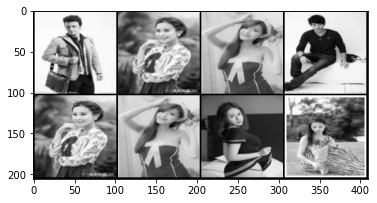

[[0.]
 [0.]
 [1.]
 [0.]]


In [22]:
train_dataloader = DataLoader(siamese_dataset,
                            shuffle=True,
                            batch_size=4)
# 看看数据集
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=4)
example_batch = next(iter(vis_dataloader)) #生成一批图像
#其中example_batch[0] 维度为torch.Size([8, 1, 100, 100])

#torch.cat是将两个张量（tensor）拼接在一起

concatenated = torch.cat((example_batch[0],example_batch[1]),0) 
imshow(torchvision.utils.make_grid(concatenated, nrow=4))
print(example_batch[2].numpy())